In [2]:
import importlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import misc
importlib.reload(misc)

<module 'misc' from '/Users/K/works/git/decumulation/misc.py'>

In [3]:
# 各資産の年率期待リターン
mu_assets = {
    "asset0": 1.43*1e-02,
    "asset1": 5.19*1e-02,
    "asset2": 3.46*1e-02,
    "asset3": 0.86*1e-02,
    "asset4": 5.95*1e-02,
    "asset5": 2.67*1e-02,
    "asset6": 5.84*1e-02,
    "asset7": 7.28*1e-02,
    "asset8": 0,
}
# 各資産の年率期待リスク
sig_assets = {
    "asset0": np.sqrt(2.36*1e-02),
    "asset1": np.sqrt(14.60*1e-02),
    "asset2": np.sqrt(7.48*1e-02),
    "asset3": np.sqrt(4.75*1e-02),
    "asset4": np.sqrt(17.13*1e-02),
    "asset5": np.sqrt(14.45*1e-02),
    "asset6": np.sqrt(14.46*1e-02),
    "asset7": np.sqrt(18.99*1e-02),
    "asset8": 0,
}

In [4]:
# 各リスク許容度RTごとのポートフォリオのボラティリティと期待リターンとアロケーション
weights = pd.DataFrame()
weights["RT"] = np.arange(0, 10, 1)
weights["Vol"] = [0, 0.0243, 0.0326, 0.0431, 0.0586, 0.0735, 0.0891, 0.1076, 0.1199, 0.1291]
weights["E[r]"] = [0.0001, 0.0165, 0.0214, 0.0274, 0.0335, 0.039, 0.0439, 0.0491, 0.053, 0.0556]
weights["asset0"] = [0, 0.2, 0.26, 0.3, 0.23, 0.18, 0.13, 0.07, 0.03, 0]
weights["asset1"] = [0, 0.06, 0.09, 0.1, 0.13, 0.16, 0.18, 0.21, 0.23, 0.24]
weights["asset2"] = [0, 0.14, 0.18, 0.23, 0.22, 0.2, 0.19, 0.16, 0.15, 0.11]
weights["asset3"] = [0, 0.16, 0.2, 0.24, 0.19, 0.14, 0.09, 0.04, 0, 0]
weights["asset4"] = [0, 0.02, 0.02, 0.03, 0.08, 0.12, 0.17, 0.22, 0.25, 0.29]
weights["asset5"] = [0, 0, 0, 0, 0, 0, 0.01, 0.04, 0.05, 0.05]
weights["asset6"] = [0, 0.04, 0.06, 0.08, 0.1, 0.12, 0.12, 0.12, 0.13, 0.13]
weights["asset7"] = [0, 0, 0, 0.02, 0.05, 0.08, 0.11, 0.14, 0.16, 0.18]
weights["asset8"] = [1, 0.38, 0.19, 0, 0, 0, 0, 0, 0, 0]

In [5]:
# ---- Simulation helpers ----
def annual_to_period_params(mu_a: float, sig_a: float, periods_per_year: int, model: str = "gaussian"):
    P = periods_per_year
    if model == "gaussian":
        mu_p = mu_a / P
        sig_p = sig_a / np.sqrt(P)
        return mu_p, sig_p
    elif model == "gbm":
        mu_log_p = np.log(1.0 + mu_a) / P
        sig_log_p = sig_a / np.sqrt(P)
        return mu_log_p, sig_log_p
    else:
        raise ValueError("model must be 'gaussian' or 'gbm'")

def simulate_returns(mu_dict, sig_dict, n_periods=120, freq="M", model="gaussian", corr=None, seed=42):
    rng = np.random.default_rng(seed)
    assets = list(mu_dict.keys())
    n = len(assets)
    if freq == "M":
        P = 12
    elif freq == "W":
        P = 52
    elif freq == "D":
        P = 252
    else:
        raise ValueError("freq must be one of 'M', 'W', 'D'")

    if corr is None:
        R = np.eye(n)
    else:
        R = corr.reindex(index=assets, columns=assets).to_numpy()

    if model == "gaussian":
        mu_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[0] for a in assets])
        sig_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gaussian")[1] for a in assets])
        D = np.diag(sig_p)
        cov = D @ R @ D
        shocks = rng.multivariate_normal(mean=np.zeros(n), cov=cov, size=n_periods)
        rets = shocks + mu_p
    else:
        mu_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[0] for a in assets])
        sig_log_p = np.array([annual_to_period_params(mu_dict[a], sig_dict[a], P, "gbm")[1] for a in assets])
        D = np.diag(sig_log_p)
        cov_log = D @ R @ D
        eps = rng.multivariate_normal(mean=np.zeros(n), cov=cov_log, size=n_periods)
        rets = np.exp(mu_log_p + eps) - 1.0

    idx = pd.date_range(start="2005-01-31", periods=n_periods, freq=freq)
    df = pd.DataFrame(rets, index=idx, columns=assets)
    return df

# ---- Run a default simulation (monthly, 10 years = 120 periods) ----
df_returns = simulate_returns(mu_assets, sig_assets, n_periods=120, freq="M", model="gaussian", corr=None, seed=123)

In [6]:
# ブートストラップ法でリサンプリング
def bootstrap(rets, n_steps):
    return rets.sample(n_steps, replace=True).values

In [49]:
class GlidePathPortfolio:
    def __init__(self, weights):
        self.weights = weights.iloc[:, 3:].values
        self.sigma = weights.iloc[:, 1].values
        self.mu = weights.iloc[:, 2].values
        self.dt = 1/12
        self.k = -0.842

    def get_scenario(self, rt, init_val, contri, withdr):
        except_ret = (self.mu[rt] - 0.5 * np.power(self.sigma[rt], 2)) * self.dt
        val = init_val * np.exp(except_ret)
        val += contri
        val -= withdr
        return val
    
    def run(self, rets, init_rt, init_val, contribution, withdrawal, const):
        n = rets.shape[0] + 1
        m = rets.shape[1]
        current_idx = 0
        end_idx = n - 1

        rt = init_rt
        contributions = contribution * np.ones(n)
        withdrawals = withdrawal * np.ones(n)
        total_withdrawal = 0

        S = np.zeros(n)
        S[current_idx] = init_val
        w = np.zeros((n, m))
        w[current_idx] = self.weights[rt]
        x = np.zeros((n, m))
        x[current_idx] = self.weights[rt] * (init_val + contributions[current_idx])
        scenario = np.zeros(n)
        scenario[current_idx] = init_val
        record_withdrawals = np.zeros(n)
        record_withdrawals[current_idx] = 0
        record_rt = np.zeros(n)
        record_rt[current_idx] = rt
        while True:
            current_idx += 1
            withdrawal_const = 1 if const else (S[current_idx-1] / scenario[current_idx-1] if scenario[current_idx-1] != 0 else 1.0)
            scenario[current_idx] = self.get_scenario(rt, scenario[current_idx-1], contributions[current_idx-1], withdrawals[current_idx-1])
            S[current_idx] = np.dot(1 + rets[current_idx-1], x[current_idx-1])
            S[current_idx] += contributions[current_idx]
            current_withdrawal = (withdrawals[current_idx] * withdrawal_const) if S[current_idx] >= (withdrawals[current_idx] * withdrawal_const) else S[current_idx]
            S[current_idx] -= current_withdrawal
            total_withdrawal -= current_withdrawal
            record_withdrawals[current_idx] = current_withdrawal

            if np.abs(np.sum(w[current_idx-1] - self.weights[rt])) > 0:
                x[current_idx] = S[current_idx] * self.weights[rt]
            else:
                x[current_idx] = x[current_idx-1] * (1 + rets[current_idx-1])
                x[current_idx] += (contributions[current_idx] * self.weights[rt])
                x_withdrawal = (withdrawals[current_idx]* self.weights[rt]) * withdrawal_const
                x_withdrawal = x_withdrawal if np.sum(x[current_idx]) >= np.sum(x_withdrawal) else x[current_idx]
                x[current_idx] -= x_withdrawal
            
            if S[current_idx] > 0:
                w[current_idx] = x[current_idx] / S[current_idx]
            else:
                w[current_idx] = 0

            X1 = total_withdrawal + scenario[current_idx-1] * np.exp(
                (self.mu[rt] - 0.5 * np.power(self.sigma[rt], 2)) * self.dt + self.sigma[rt] * np.sqrt(self.dt) * self.k
            )
            X2 = (total_withdrawal + scenario[current_idx-1]) * np.exp(
                (self.mu[init_rt] - 0.5 * np.power(self.sigma[init_rt], 2)) * self.dt + self.sigma[init_rt] * np.sqrt(self.dt) * self.k
            )
            rt = rt if X1 >= X2 else np.maximum(rt - 1, 0)
            record_rt[current_idx] = rt
            if current_idx == end_idx:
                break
            
        self.scenario = scenario
        self.record_withdrawals = record_withdrawals
        self.total_withdrawal = total_withdrawal
        self.record_rt = record_rt
        return S, x, w

In [50]:
INIT_VAL = 100
WITHDRAWAL_RATE = 0.03 / 12 # per month
RT = 4
N_STEPS = 12 * 35 # month
N_PATHS = 10
AGE = np.arange(65, 100+1/12, 1/12)

rets = bootstrap(df_returns, n_steps=N_STEPS)

In [51]:
model = GlidePathPortfolio(weights)

In [52]:
S, _, _ = model.run(
    rets=rets,
    init_rt=RT,
    init_val=INIT_VAL,
    contribution=0,
    withdrawal=WITHDRAWAL_RATE*INIT_VAL,
    const=False
)

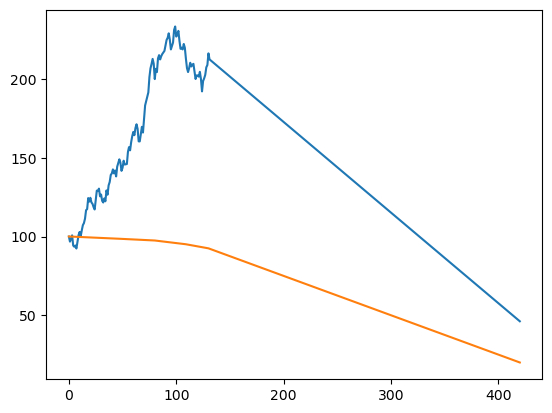

In [53]:
plt.plot(S)
plt.plot(model.scenario)
plt.show()

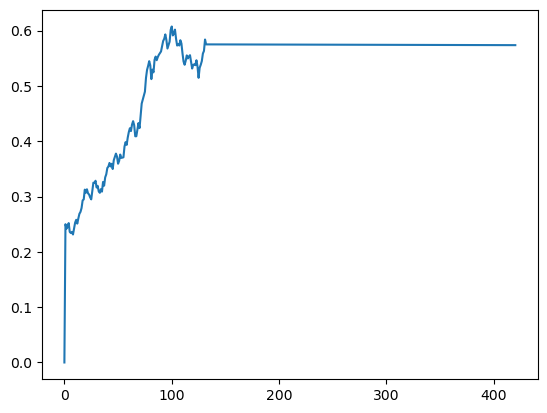

In [54]:

plt.plot(model.record_withdrawals)
plt.show()

In [55]:
model.record_rt

array([4., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.